In [75]:
# Import necessary libraries

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [76]:
# Define global parameters

timeframe_days = 7  # Number of days to consider (max 7 with this file)
timeframe_hours = timeframe_days * 8  # Convert to 3-hours timeframe
pool_fees = 0.0005 # Fees of the simulated pool (0.05%)

In [77]:
# Read data from CSV file and convert the timestamp column to datetime format

x = pd.read_csv("ETH_7D_graph_coinmarketcap.csv",delimiter=";")
x["timestamp"] = x['timestamp'].apply(lambda x : datetime.fromisoformat(x))
x = x.set_index("timestamp")
eth_price = x["open"][-timeframe_hours:]

In [78]:
# Create a DataFrame for ETH price data and determine enters and exits of the specified price range
def compute_transitions(eth_price,lower_tick,higher_tick):
    df_eth_price = pd.DataFrame(eth_price)
    enters_range = (df_eth_price["open"] >= lower_tick) & (df_eth_price["open"].shift(1)<lower_tick)
    exits_range =  (df_eth_price["open"] <= higher_tick) & (df_eth_price["open"].shift(1)>higher_tick)
    transitions = enters_range | exits_range
    transitions = transitions.astype(int)*pool_fees
    return transitions

In [79]:
class LP_position():

    def __init__(self,lower_tick,higher_tick,eth_supplied):

        self.lower_tick = lower_tick
        self.higher_tick = higher_tick
        self.eth_supplied = eth_supplied
    """
    These functions are used to compute LP value and corresponding fees

    The LP value represents the liquidity position value in USDC at a given timestamp based on the price of ETH

    If the ETH price is below the lower tick the LP position is not active and it's only ETH
    If the ETH price is above the higher tick, the LP position is not actve and it's only USDC, the value is computed using uniswap constant product formula
    If the ETH price is within the range, the LP position is active and its value is computed using uniswap constant product formula 
    """
    def LP_value(self,eth_price):
        return eth_price.apply(lambda x: eth_supplied*x if x < self.lower_tick 
                                else self.eth_supplied*np.sqrt(self.lower_tick*self.higher_tick) if x > self.higher_tick 
                                else self.eth_supplied*(np.sqrt(self.lower_tick*x)))
    
    """
    The 'transitions' variable indicates whether Ether price visits the LP range 
    For each transition, LP accumulates fees paid by traders depending on the parameters of the pool
    The fees are cumulatively added over time to track the total fees accumulated 
    """
    def fees(self,eth_price):
        transitions = compute_transitions(eth_price,self.lower_tick,self.higher_tick)
        return (transitions*self.eth_supplied*np.sqrt(self.lower_tick*eth_price)).cumsum()


In [80]:
class portfolio():
    
    def __init__(self):
        self.positions = []
        self.debt = 0
        self.ptf = pd.Series(dtype=float)

    def add_position(self,lower_tick,higher_tick,eth_supplied):
        pos = LP_position(lower_tick,higher_tick,eth_supplied)
        (self.positions).append(pos)
    
    def add_debt(self,eth_borrowed):
        self.debt = eth_borrowed

    def compute_ptf_value(self,eth_price):
        fee_tmp_series = 0*eth_price
        LP_tmp_series = 0*eth_price

        for position in self.positions : 
            # Calculate the portfolio value, fees and LP value
            fee_tmp_series = fee_tmp_series + position.fees(eth_price)
            LP_tmp_series =  LP_tmp_series + position.LP_value(eth_price)
        
        self.ptf["LP value"] = LP_tmp_series

        self.ptf["fees"] = fee_tmp_series

        # The liquidity provider borrows some ETH to provide liquidity
        self.ptf["debt"] = eth_borrowed*eth_price

        # The portfolio value is the difference between the LP value and the debt amount
        self.ptf["ptf value"] = self.ptf["LP value"] + self.ptf["fees"] -self.ptf["debt"] 

        # The portfolio's profit
        self.ptf["profit"] = self.ptf["ptf value"] - self.ptf["ptf value"][0]

        # Value used to compute the payoff at the end of the simulation
        self.ptf["payoff"] = self.ptf["LP value"] - self.ptf["debt"] + self.ptf["fees"][-1]

In [81]:
eth_borrowed = 0.1  # Amount of ETH borrowed for liquidity provision
lower_tick = 1876  # Lower tick value for the range
higher_tick = 1878  # Higher tick value for the range

eth_supplied = eth_borrowed #Amount to supply

# Initialization of the portfolio to simulate
user_ptf = portfolio()

# Adding LP positions
user_ptf.add_position(1876,1878,0.1)
user_ptf.add_position(1860,1862,0.1)

# Adding a short position
user_ptf.add_debt(0.1)

# Simulation of the portfolio
user_ptf.compute_ptf_value(eth_price)

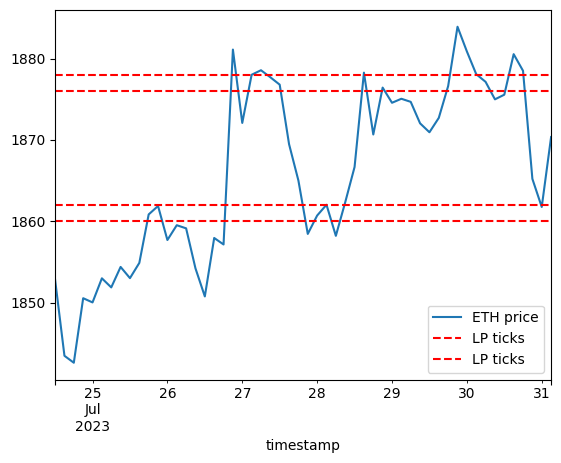

In [82]:
# Plot ETH price over the selected timeframe

eth_price.plot(label="ETH price")

for position in user_ptf.positions:
    plt.axhline(position.lower_tick,linestyle="--",color = "r",label="LP ticks")
    plt.axhline(position.higher_tick,linestyle="--",color = "r")
    
plt.legend()
plt.show()

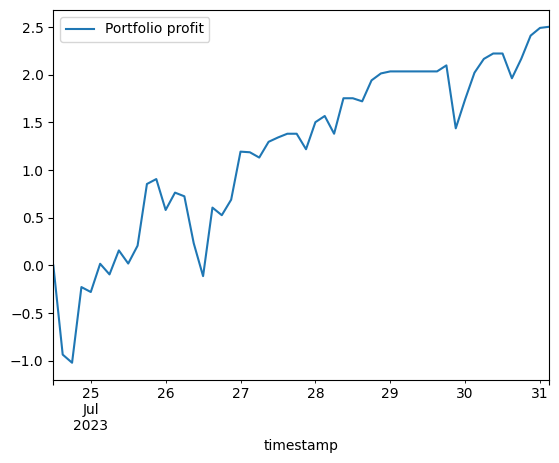

In [85]:
# Plot total portfolio value and its components

(user_ptf.ptf["profit"]).plot(label="Portfolio profit")
plt.legend()
plt.show()

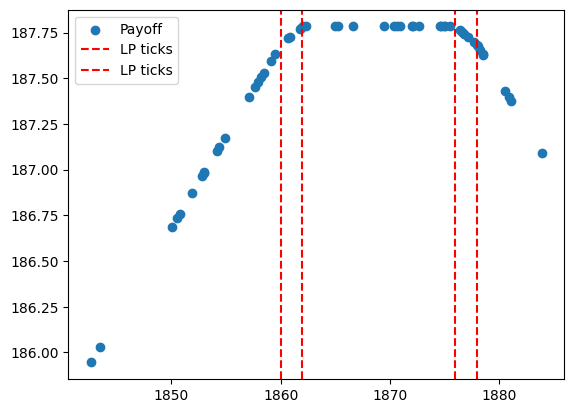

In [84]:
# Plot the payoff based on ETH price and total portfolio value at the end of the selected timeframe

plt.scatter(eth_price,user_ptf.ptf["payoff"],label="Payoff")

for position in user_ptf.positions : 
    plt.axvline(position.lower_tick,linestyle="--",color = "r",label="LP ticks")
    plt.axvline(position.higher_tick,linestyle="--",color = "r")

plt.legend()
plt.show()